In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

In [29]:
import catboost as cb
import lightgbm as lgb
import xgboost as xgb

In [30]:
def show_all(df, nrow=None, ncol=None):
    with pd.option_context('display.max_rows', nrow, 'display.max_columns', ncol):
        display(df)

In [31]:
train_df = pd.read_csv('../input/train1.csv')
test_df = pd.read_csv('../input/test1.csv')

In [32]:
show_all(train_df.head())

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,days_stay,how_early_book,total_people,same_state_travel,rooms,person_per_room,diff_pax_total
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,2018-04-05,2018-04-05,2018-04-06,3,1,2,0,46,3,3,3,1,2.0,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,7,7.706428,1,0,2,0,1.0,3.0,1
1,03930f033646d073462b35d411616323597715ac4fc398...,2015-01-23,2015-04-11,2015-04-16,1,1,2,0,46,3,3,4,5,2.0,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,1,6.662563,5,78,2,0,1.0,2.0,0
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,2015-01-28,2015-02-01,2015-02-05,1,1,2,0,47,1,5,4,4,2.0,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,9,7.871602,4,4,2,0,1.0,2.0,0
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,2015-05-02,2015-06-11,2015-06-16,1,1,2,2,46,2,2,3,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,25,5.344943,5,40,4,0,1.0,2.0,-2
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,2015-09-02,2015-12-14,2015-12-19,1,1,2,0,46,2,2,4,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,25,7.059346,5,103,2,0,1.0,2.0,0


### create some features

In [33]:
train_df['season_holidayed_code'] = train_df['season_holidayed_code'].astype(int)
test_df['season_holidayed_code'] = test_df['season_holidayed_code'].astype(int)

train_df['state_code_residence'] = train_df['state_code_residence'].astype(int)
test_df['state_code_residence'] = test_df['state_code_residence'].astype(int)

In [34]:
train_df['member_age_buckets'].unique()

array(['F', 'H', 'D', 'E', 'I', 'G', 'C', 'B', 'A', 'J'], dtype=object)

In [35]:
mapper = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9}

In [36]:
train_df['member_age_buckets'] = train_df['member_age_buckets'].map(mapper)
test_df['member_age_buckets'] = test_df['member_age_buckets'].map(mapper)

In [37]:
train_df['checkin_date'] = pd.to_datetime(train_df['checkin_date'])
test_df['checkin_date'] = pd.to_datetime(test_df['checkin_date'])

In [38]:
train_df['year'] = train_df['checkin_date'].dt.year
test_df['year'] = test_df['checkin_date'].dt.year

train_df['month'] = train_df['checkin_date'].dt.month
test_df['month'] = test_df['checkin_date'].dt.month

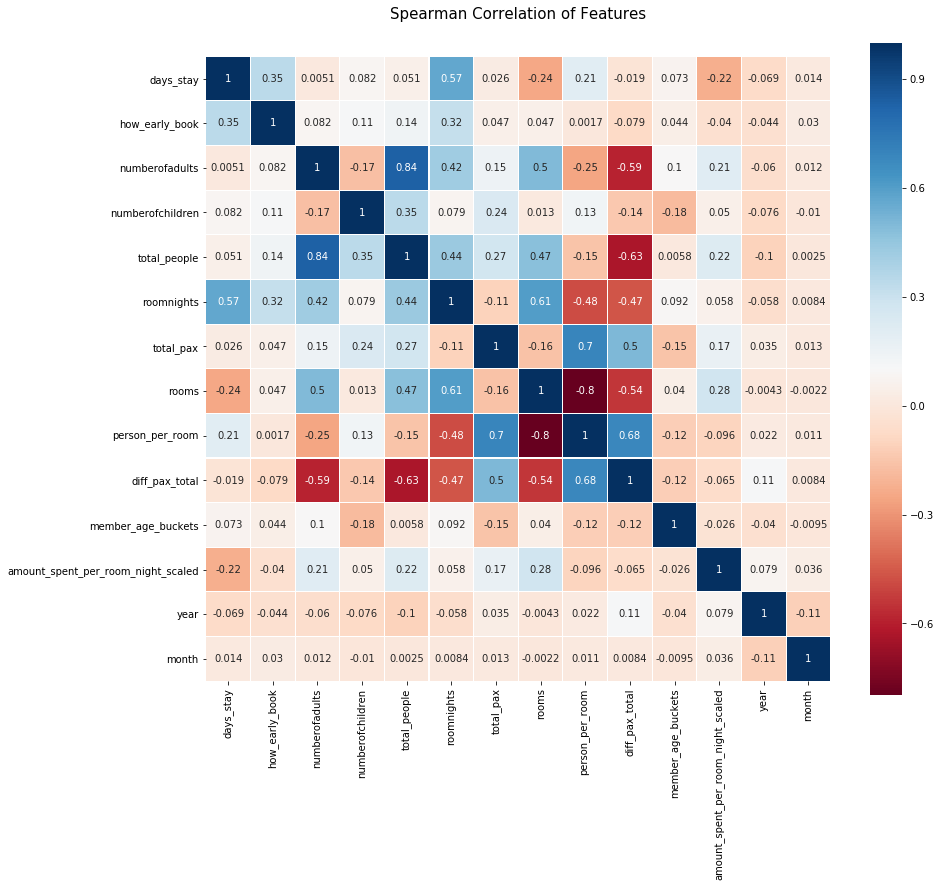

In [39]:
cor = train_df[['days_stay', 'how_early_book', 'numberofadults', 'numberofchildren', 'total_people', 'roomnights', 'total_pax', 'rooms', 'person_per_room', 'diff_pax_total', 'member_age_buckets', 'amount_spent_per_room_night_scaled', 'year', 'month']].corr(method='spearman') 
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Spearman Correlation of Features', y=1.05, size=15)
sns.heatmap(cor,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [40]:
target_col_name = 'amount_spent_per_room_night_scaled'

### Use catboost and find feature importance, adn select fetures or all final models

In [ ]:
features = [col for col in test_df.columns if col not in ['reservation_id', 'booking_date', 'checkin_date', 'checkout_date', 'memberid']]   

In [ ]:
pd.Series(features)

In [ ]:
len(features)

In [ ]:
cat_inds = [0, 1, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 21]

In [ ]:
len(cat_inds)

In [41]:
def cv_metric(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted)) * 100

In [55]:
def run_cv_model(train, features, target, model_fn, params={}, n_splits=5, test=None, label='model', cv_verbose = False, model_verbose=False):
    kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    fold_splits = kf.split(train[features], train[target], groups=train['memberid'])
    cv_scores = []
    pred_full_test = np.zeros((test.shape[0], n_splits))
    pred_train = np.zeros((train.shape[0], n_splits))
    feature_importance_df = pd.DataFrame()
    target = train[target]
    train = train[features]
    i = 1
    for dev_index, val_index in fold_splits:
        if cv_verbose:
            print('Started ' + label + ' fold ' + str(i) + '/'+str(n_splits))
        if isinstance(train, pd.DataFrame):
            dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        else:
            dev_X, val_X = train[dev_index], train[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y, importances, cv_score = model_fn(dev_X, dev_y, val_X, val_y, test[features], params2, model_verbose)
        pred_full_test[:, i-1] = pred_test_y.flatten()
        pred_train[val_index] = pred_val_y
        
        cv_scores.append(cv_score)
        
        if cv_verbose:
            print(label + ' cv score {}: (RMSE * 100) {}'.format(i, cv_score))
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = train.columns.values
        fold_importance_df['importance'] = importances
        fold_importance_df['fold'] = i
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)        
            
        i += 1
    
    if cv_verbose:
        print("\n\n CV - Report\n")
        print('{} cv (RMSE * 100) scores : {}'.format(label, cv_scores))
        print('{} cv mean (RMSE * 100) score : {}'.format(label, np.mean(cv_scores)))
        print('{} cv std (RMSE * 100) score : {}'.format(label, np.std(cv_scores)))
        
    results = {'label': label,
               'train': pred_train, 'test': pred_full_test,
                'cv': cv_scores,
               'importance': feature_importance_df}
    return results

In [56]:
def runCatBoostReg(train_X, train_y, test_X, test_y, test_X2, params, model_verbose):
    if model_verbose:
        print('Prep Catboost Regressor')
    cat_ind = params.pop('cat_features')
    val_pool = cb.Pool(test_X.values, test_y.values, cat_features=cat_ind)
    model = cb.CatBoostRegressor()
    model.set_params(** params)
    if model_verbose:
        print('Train Catboost Regressor')
    model.fit(X=train_X, y=train_y, eval_set=val_pool, cat_features=cat_ind, use_best_model=True)
    
    if model_verbose:
        print('Predict validation set')
    pred_test_y = model.predict(test_X)
    cv_score = cv_metric(test_y, pred_test_y)
    if model_verbose:
        print('Predict actual test set')
    if test_X2 is not None:
        pred_test_y2 = model.predict(test_X2)
        pred_test_y2 = pred_test_y2.reshape(-1, 1)
    else:
        pred_test_y2 = 0
    pred_test_y = pred_test_y.reshape(-1, 1)
    return pred_test_y, pred_test_y2, model.feature_importances_, cv_score

In [ ]:
catboost_params = {'iterations': 10000,
                   # 'learning_rate': 0.01,
                   # 'depth': 10,
                   'loss_function': 'RMSE',
                   'eval_metric': 'RMSE',
                   'random_seed': 0,
                   # 'l2_leaf_reg': 5,
                   'early_stopping_rounds': 600,
                   'use_best_model': True,
                   'verbose': 100,
                   # 'random_strength': 0,
                   'task_type': 'GPU',
                   # 'bootstrap_type': 'Bernoulli',
                   # 'subsample': 0.99,
                   'cat_features': cat_inds}

results = run_cv_model(train_df, features, target_col_name, runCatBoostReg, catboost_params, n_splits=5, test=test_df, label='CatBoost', cv_verbose=True, model_verbose=True)

In [ ]:
imports = results['importance'].groupby('feature')['importance'].describe().reset_index()
show_all(imports.sort_values('mean', ascending=False).reset_index(drop=True))

In [ ]:
sub_df = pd.DataFrame({'reservation_id': test_df['reservation_id']})
sub_df[target_col_name] = np.mean(results['test'], axis=1)
sub_df.head()

In [ ]:
sns.distplot(sub_df[target_col_name])

In [ ]:
sns.distplot(train_df[target_col_name])

In [ ]:
# 96.2951581235 public LB 
# 97.70958556957382 +/- 0.24181 CV
sub_df.to_csv('cat1.csv', index=False)

In [44]:
from IPython.display import FileLink

In [ ]:
FileLink('cat1.csv')

### Final features

In [45]:
features = [col for col in test_df.columns if col not in ['reservation_id', 'booking_date', 'checkin_date', 'checkout_date', 'memberid', 'numberofadults', 'numberofchildren', 'total_people', 'roomnights', 'person_per_room', 'same_state_travel']]

In [46]:
# all feature columns
pd.Series(features)

0                 channel_code
1            main_product_code
2           persontravellingid
3           resort_region_code
4             resort_type_code
5        room_type_booked_code
6        season_holidayed_code
7         state_code_residence
8            state_code_resort
9                    total_pax
10          member_age_buckets
11           booking_type_code
12                cluster_code
13    reservationstatusid_code
14                   resort_id
15                   days_stay
16              how_early_book
17                       rooms
18              diff_pax_total
19                        year
20                       month
dtype: object

In [47]:
cat_inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14]

In [48]:
# categorical columns
cat_cols = np.array(features)[cat_inds].tolist()
pd.Series(cat_cols)

0                 channel_code
1            main_product_code
2           persontravellingid
3           resort_region_code
4             resort_type_code
5        room_type_booked_code
6        season_holidayed_code
7         state_code_residence
8            state_code_resort
9            booking_type_code
10                cluster_code
11    reservationstatusid_code
12                   resort_id
dtype: object

In [49]:
num_cols = [col for col in features if col not in cat_cols]

In [50]:
num_cols

['total_pax',
 'member_age_buckets',
 'days_stay',
 'how_early_book',
 'rooms',
 'diff_pax_total',
 'year',
 'month']

### Catboost

- CV result : 97.73327151706556 +/- 0.2448
- Public LB result : 	96.3428538635586

In [57]:
catboost_params = {'iterations': 15000,
                   'learning_rate': 0.03,
                   'depth': 7,
                   'loss_function': 'RMSE',
                   'eval_metric': 'RMSE',
                   'random_seed': 0,
                   'l2_leaf_reg': 5,
                   'early_stopping_rounds': 600,
                   'use_best_model': True,
                   'verbose': 300,
                   # 'random_strength': 0,
                   'task_type': 'GPU',
                   # 'bootstrap_type': 'Bernoulli',
                   # 'subsample': 0.99,
                   'cat_features': cat_inds}

results_catboost = run_cv_model(train_df, features, target_col_name, runCatBoostReg, catboost_params, n_splits=5, test=test_df, label='CatBoost', cv_verbose=True, model_verbose=True)

Started CatBoost fold 1/5
Prep Catboost Regressor
Train Catboost Regressor
0:	learn: 7.5687577	test: 7.5649425	best: 7.5649425 (0)	total: 45.5ms	remaining: 11m 22s
300:	learn: 0.9795242	test: 0.9873566	best: 0.9873566 (300)	total: 13.2s	remaining: 10m 45s
600:	learn: 0.9745160	test: 0.9848486	best: 0.9848486 (600)	total: 26.1s	remaining: 10m 25s
900:	learn: 0.9715357	test: 0.9839445	best: 0.9839445 (900)	total: 38.6s	remaining: 10m 3s
1200:	learn: 0.9690111	test: 0.9833988	best: 0.9833979 (1196)	total: 51.6s	remaining: 9m 52s
1500:	learn: 0.9668102	test: 0.9830239	best: 0.9830239 (1500)	total: 1m 3s	remaining: 9m 34s
1800:	learn: 0.9646241	test: 0.9827225	best: 0.9827225 (1800)	total: 1m 16s	remaining: 9m 17s
2100:	learn: 0.9626069	test: 0.9825483	best: 0.9825483 (2100)	total: 1m 28s	remaining: 9m 1s
2400:	learn: 0.9606378	test: 0.9823413	best: 0.9823410 (2399)	total: 1m 39s	remaining: 8m 43s
2700:	learn: 0.9586308	test: 0.9822213	best: 0.9822213 (2700)	total: 1m 51s	remaining: 8m 28s


2400:	learn: 0.9610434	test: 0.9769446	best: 0.9769446 (2400)	total: 1m 39s	remaining: 8m 40s
2700:	learn: 0.9590429	test: 0.9768207	best: 0.9768188 (2694)	total: 1m 51s	remaining: 8m 25s
3000:	learn: 0.9570548	test: 0.9766918	best: 0.9766810 (2982)	total: 2m 3s	remaining: 8m 13s
3300:	learn: 0.9551498	test: 0.9766311	best: 0.9766256 (3292)	total: 2m 15s	remaining: 7m 59s
3600:	learn: 0.9531514	test: 0.9766185	best: 0.9765941 (3432)	total: 2m 27s	remaining: 7m 46s
3900:	learn: 0.9511727	test: 0.9765465	best: 0.9765413 (3881)	total: 2m 39s	remaining: 7m 32s
4200:	learn: 0.9492786	test: 0.9765031	best: 0.9765027 (4197)	total: 2m 50s	remaining: 7m 18s
4500:	learn: 0.9474033	test: 0.9765199	best: 0.9764995 (4422)	total: 3m 2s	remaining: 7m 5s
4800:	learn: 0.9454963	test: 0.9764794	best: 0.9764788 (4792)	total: 3m 14s	remaining: 6m 52s
5100:	learn: 0.9436921	test: 0.9765492	best: 0.9764741 (4811)	total: 3m 26s	remaining: 6m 40s
5400:	learn: 0.9418917	test: 0.9765219	best: 0.9764741 (4811)	t

In [60]:
imports_catboost = results_catboost['importance'].groupby('feature')['importance'].describe().reset_index()
show_all(imports_catboost.sort_values('mean', ascending=False).reset_index(drop=True))

,feature,count,mean,std,min,25%,50%,75%,max
0,rooms,5.0,14.348445,0.648030,13.388722,14.210575,14.403462,14.558944,15.180525
1,days_stay,5.0,11.370550,0.803295,10.525786,10.703728,11.211175,12.179588,12.232474
2,resort_id,5.0,8.397939,0.194629,8.191111,8.299172,8.321457,8.488612,8.689345
3,total_pax,5.0,7.319636,0.418752,6.672147,7.125070,7.560201,7.567718,7.673046
4,diff_pax_total,5.0,6.918368,0.177202,6.684678,6.789506,6.965441,7.041427,7.110789
5,persontravellingid,5.0,6.647049,0.220817,6.482994,6.484829,6.620130,6.625259,7.022032
6,state_code_residence,5.0,5.748948,0.355221,5.340699,5.534760,5.660645,5.978204,6.230433
7,how_early_book,5.0,5.731585,0.267198,5.524565,5.564809,5.595454,5.804390,6.168706
8,main_product_code,5.0,4.093547,0.225533,3.967317,3.967401,4.015764,4.022978,4.494275
9,state_code_resort,5.0,3.600930,0.269117,3.196279,3.487449,3.681571,3.745935,3.893413


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


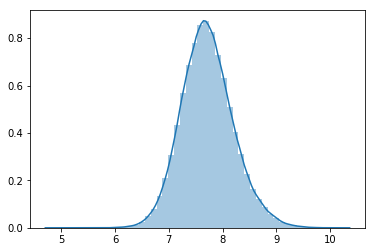

In [61]:
# distribution of predictions of train dataset
# predictions from catboost always gives normal distribution but actually it it not
sns.distplot(results_catboost['train'].mean(axis=1))
plt.show()

In [62]:
sub_catboost = pd.DataFrame({'reservation_id': test_df['reservation_id']})
sub_catboost[target_col_name] = np.mean(results_catboost['test'], axis=1)
sub_catboost.to_csv('catboost_sub.csv', index=False)
FileLink('catboost_sub.csv')

/kaggle/working/catboost_sub.csv

### LightGBM
- CV result : 97.72251618085228 +/- 0.2391
- Public LB : 	96.3575889874544

In [63]:
# convert categorical cols to category type, so LGBM can use it as an categorical columns
train_df[cat_cols] = train_df[cat_cols].astype('category')
test_df[cat_cols] = test_df[cat_cols].astype('category')

In [64]:
def runLGB(train_X, train_y, test_X, test_y, test_X2, params, model_verbose):
    if model_verbose:
        print('Prep LGBM Regressor')
    d_train = lgb.Dataset(train_X, label=train_y)
    d_valid = lgb.Dataset(test_X, label=test_y)
    watchlist = [d_train, d_valid]
    if model_verbose:
        print('Train LGBM Regressor')
    num_rounds = params.pop('num_rounds')
    verbose_eval = params.pop('verbose_eval')
    early_stop = None
    if params.get('early_stop'):
        early_stop = params.pop('early_stop')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    if model_verbose:
        print('Predict validation set')
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    cv_score = cv_metric(test_y, pred_test_y)
    if model_verbose:
        print('Predict actual test set')
    if test_X2 is not None:
        pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)
        pred_test_y2 = pred_test_y2.reshape(-1, 1)
    else:
        pred_test_y2 = 0
    pred_test_y = pred_test_y.reshape(-1, 1)
    
    return pred_test_y, pred_test_y2, model.feature_importance(), cv_score

In [65]:
lgb_params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 100,
          'max_depth': 12,
          'learning_rate': 0.01,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.8,
          'min_split_gain': 0.008,
          'min_child_samples': 150,
          'min_child_weight': 0.01,
          'reg_lambda': 3,
          'verbosity': -1,
          'data_random_seed': 0,
          'early_stop': 500,
          'verbose_eval': 500,
          'num_rounds': 10000,
          #'categorical_feature': cat_cols
        }

results_lgb = run_cv_model(train_df, features, target_col_name, runLGB, lgb_params, n_splits=5, test=test_df, label='LGBM', cv_verbose=True, model_verbose=True)

Started LGBM fold 1/5
Prep LGBM Regressor
Train LGBM Regressor


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.962943	valid_1's rmse: 0.983063
[1000]	training's rmse: 0.94978	valid_1's rmse: 0.981478
[1500]	training's rmse: 0.941083	valid_1's rmse: 0.981314
Early stopping, best iteration is:
[1386]	training's rmse: 0.942964	valid_1's rmse: 0.981273
Predict validation set
Predict actual test set
LGBM cv score 1: (RMSE * 100) 98.1272556748445
Started LGBM fold 2/5
Prep LGBM Regressor
Train LGBM Regressor


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.964911	valid_1's rmse: 0.976101
[1000]	training's rmse: 0.951797	valid_1's rmse: 0.974289
[1500]	training's rmse: 0.943089	valid_1's rmse: 0.974117
[2000]	training's rmse: 0.935114	valid_1's rmse: 0.974251
Early stopping, best iteration is:
[1584]	training's rmse: 0.941704	valid_1's rmse: 0.974077
Predict validation set
Predict actual test set
LGBM cv score 2: (RMSE * 100) 97.40765834992354
Started LGBM fold 3/5
Prep LGBM Regressor
Train LGBM Regressor


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.964212	valid_1's rmse: 0.978111
[1000]	training's rmse: 0.951001	valid_1's rmse: 0.976539
[1500]	training's rmse: 0.94224	valid_1's rmse: 0.976538
Early stopping, best iteration is:
[1157]	training's rmse: 0.948123	valid_1's rmse: 0.976481
Predict validation set
Predict actual test set
LGBM cv score 3: (RMSE * 100) 97.64807144231825
Started LGBM fold 4/5
Prep LGBM Regressor
Train LGBM Regressor


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.964331	valid_1's rmse: 0.977799
[1000]	training's rmse: 0.951175	valid_1's rmse: 0.976291
[1500]	training's rmse: 0.942405	valid_1's rmse: 0.97634
Early stopping, best iteration is:
[1243]	training's rmse: 0.94676	valid_1's rmse: 0.976217
Predict validation set
Predict actual test set
LGBM cv score 4: (RMSE * 100) 97.62168508311773
Started LGBM fold 5/5
Prep LGBM Regressor
Train LGBM Regressor


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.96371	valid_1's rmse: 0.97976
[1000]	training's rmse: 0.950265	valid_1's rmse: 0.978151
[1500]	training's rmse: 0.94127	valid_1's rmse: 0.978152
Early stopping, best iteration is:
[1239]	training's rmse: 0.945823	valid_1's rmse: 0.978079
Predict validation set
Predict actual test set
LGBM cv score 5: (RMSE * 100) 97.80791035405737


 CV - Report

LGBM cv (RMSE * 100) scores : [98.1272556748445, 97.40765834992354, 97.64807144231825, 97.62168508311773, 97.80791035405737]
LGBM cv mean (RMSE * 100) score : 97.72251618085228
LGBM cv std (RMSE * 100) score : 0.23914456125004024


In [66]:
imports_lgb = results_lgb['importance'].groupby('feature')['importance'].describe().reset_index()
show_all(imports_lgb.sort_values('mean', ascending=False).reset_index(drop=True))

,feature,count,mean,std,min,25%,50%,75%,max
0,resort_id,5.0,25670.4,2857.761152,22963.0,24199.0,24361.0,26626.0,30203.0
1,state_code_residence,5.0,19943.2,2122.958596,17919.0,18809.0,18918.0,20843.0,23227.0
2,how_early_book,5.0,13023.8,2148.469618,10763.0,12011.0,12134.0,13908.0,16303.0
3,diff_pax_total,5.0,7129.4,974.931433,6235.0,6596.0,6634.0,7533.0,8649.0
4,month,5.0,7031.0,1072.917751,5844.0,6555.0,6681.0,7397.0,8678.0
5,rooms,5.0,6506.4,794.539363,5842.0,6074.0,6114.0,6688.0,7814.0
6,total_pax,5.0,6065.8,508.218654,5590.0,5809.0,5864.0,6170.0,6896.0
7,member_age_buckets,5.0,5828.6,892.994849,5072.0,5206.0,5462.0,6167.0,7236.0
8,main_product_code,5.0,5054.4,475.721347,4417.0,4855.0,4997.0,5334.0,5669.0
9,persontravellingid,5.0,5031.0,478.518025,4626.0,4763.0,4775.0,5193.0,5798.0


In [67]:
sub_lgb = pd.DataFrame({'reservation_id': test_df['reservation_id']})
sub_lgb[target_col_name] = np.mean(results_lgb['test'], axis=1)
sub_lgb.to_csv('lgb_sub.csv', index=False)
FileLink('lgb_sub.csv')

/kaggle/working/lgb_sub.csv

## One-Hot Encoding

In [68]:
# label encode all categorical data
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

In [69]:
mm_scl = MinMaxScaler()
train_df[num_cols] = mm_scl.fit_transform(train_df[num_cols])
test_df[num_cols] = mm_scl.transform(test_df[num_cols])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [70]:
train_df.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,days_stay,how_early_book,total_people,same_state_travel,rooms,person_per_room,diff_pax_total,year,month
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,2018-04-05,2018-04-05,2018-04-06,2,0,2,0,1,2,3,2,1,1,7,2,0.125000,0.555556,0,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,5,2,7,7.706428,0.00,0.000000,2,0,0.018062,3.0,0.611111,0.857143,0.272727
1,03930f033646d073462b35d411616323597715ac4fc398...,2015-01-23,2015-04-11,2015-04-16,0,0,2,0,1,2,3,3,5,1,7,4,0.083333,0.555556,0,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,5,0,1,6.662563,0.16,0.619048,2,0,0.018062,2.0,0.592593,0.428571,0.272727
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,2015-01-28,2015-02-01,2015-02-05,0,0,2,0,2,0,5,3,4,1,7,0,0.083333,0.555556,0,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,4,0,9,7.871602,0.12,0.031746,2,0,0.018062,2.0,0.592593,0.428571,0.090909
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,2015-05-02,2015-06-11,2015-06-16,0,0,2,2,1,1,2,2,5,1,7,1,0.083333,0.555556,0,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,3,0,25,5.344943,0.16,0.317460,4,0,0.018062,2.0,0.555556,0.428571,0.454545
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,2015-09-02,2015-12-14,2015-12-19,0,0,2,0,1,1,2,3,5,1,7,1,0.083333,0.555556,0,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,3,0,25,7.059346,0.16,0.817460,2,0,0.018062,2.0,0.592593,0.428571,1.000000


In [71]:
test_df.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,days_stay,how_early_book,total_people,same_state_travel,rooms,person_per_room,diff_pax_total,year,month
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,2018-04-05,2018-04-05,2018-04-06,2,1,2,0,0,2,3,3,1,1,2,2,0.125000,0.777778,0,2114944930dcc42ce5b9b50ae965cf8a9c04e46be63d84...,0,2,20,0.00,0.000000,2,0,0.018062,3.0,0.611111,0.857143,0.272727
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,2015-05-24,2015-06-23,2015-06-27,0,1,4,0,0,0,1,3,8,1,2,3,0.083333,0.777778,0,2114944930dcc42ce5b9b50ae965cf8a9c04e46be63d84...,5,0,28,0.12,0.238095,4,0,0.039409,1.0,0.555556,0.428571,0.454545
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,2015-07-21,2015-08-07,2015-08-10,2,1,3,0,0,1,2,1,3,3,2,1,0.125000,0.777778,0,2114944930dcc42ce5b9b50ae965cf8a9c04e46be63d84...,3,0,25,0.08,0.134921,3,1,0.018062,3.0,0.592593,0.428571,0.636364
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,2015-07-31,2015-10-22,2015-10-25,0,1,3,0,0,0,1,1,3,1,2,5,0.125000,0.777778,0,2114944930dcc42ce5b9b50ae965cf8a9c04e46be63d84...,5,0,5,0.08,0.658730,3,0,0.018062,3.0,0.592593,0.428571,0.818182
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,2016-07-01,2016-10-01,2016-10-05,0,1,4,0,0,0,2,2,8,1,2,9,0.083333,0.777778,0,2114944930dcc42ce5b9b50ae965cf8a9c04e46be63d84...,5,0,27,0.12,0.730159,4,0,0.039409,1.0,0.555556,0.571429,0.818182


In [72]:
one_hot_enc = OneHotEncoder(sparse=False)

In [73]:
print('Original number of features: \n', train_df[features].shape[1], "\n")
data_ohe_train = (one_hot_enc.fit_transform(train_df[cat_cols]))
data_ohe_test = (one_hot_enc.transform(test_df[cat_cols]))

train_ohe = np.concatenate([train_df[num_cols].values, data_ohe_train], axis=1)
test_ohe = np.concatenate([test_df[num_cols].values, data_ohe_test], axis=1)
train_ohe = pd.DataFrame(train_ohe)
test_ohe = pd.DataFrame(test_ohe)
train_ohe[target_col_name] = train_df[target_col_name]
train_ohe['memberid'] = train_df['memberid']

print('Features after OHE: \n', test_ohe.shape[1])

Original number of features: 
 21 



/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Features after OHE: 
 135


In [74]:
features_ohe = test_ohe.columns

In [75]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [79]:
def run_linear_cv_model(train, features, target, model_fn, params={}, n_splits=5, test=None, label='model', cv_verbose = False, model_verbose=False):
    kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    fold_splits = kf.split(train[features], train[target], groups=train['memberid'])
    cv_scores = []
    pred_full_test = np.zeros((test.shape[0], n_splits))
    pred_train = np.zeros((train.shape[0], n_splits))
    target = train[target]
    train = train[features]
    i = 1
    for dev_index, val_index in fold_splits:
        if cv_verbose:
            print('Started ' + label + ' fold ' + str(i) + '/'+str(n_splits))
        if isinstance(train, pd.DataFrame):
            dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        else:
            dev_X, val_X = train[dev_index], train[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y, importances, cv_score = model_fn(dev_X, dev_y, val_X, val_y, test[features], params2, model_verbose)
        pred_full_test[:, i-1] = pred_test_y.flatten()
        pred_train[val_index] = pred_val_y
        
        cv_scores.append(cv_score)
        
        if cv_verbose:
            print(label + ' cv score {}: (RMSE * 100) {}'.format(i, cv_score))    
        i += 1
    
    if cv_verbose:
        print("\n\n CV - Report\n")
        print('{} cv (RMSE * 100) scores : {}'.format(label, cv_scores))
        print('{} cv mean (RMSE * 100) score : {}'.format(label, np.mean(cv_scores)))
        print('{} cv std (RMSE * 100) score : {}'.format(label, np.std(cv_scores)))
        
    results = {'label': label,
               'train': pred_train, 'test': pred_full_test,
                'cv': cv_scores}
    return results

### Elastic Net
- CV score - 109.01069156428464 +/- 0.1914

In [80]:
def runElasticNet(train_X, train_y, test_X, test_y, test_X2, params, model_verbose):
    if model_verbose:
        print('Prep EN Regressor')
        
    model = ElasticNet()
    model.set_params(** params)

    if model_verbose:
        print('Train EN Regressor')
    model.fit(X=train_X, y=train_y)
    
    if model_verbose:
        print('Predict validation set')
    pred_test_y = model.predict(test_X)
    cv_score = cv_metric(test_y, pred_test_y)
    if model_verbose:
        print('Predict actual test set')
    if test_X2 is not None:
        pred_test_y2 = model.predict(test_X2)
        pred_test_y2 = pred_test_y2.reshape(-1, 1)
    else:
        pred_test_y2 = 0
    pred_test_y = pred_test_y.reshape(-1, 1)
    return pred_test_y, pred_test_y2, None, cv_score

In [81]:
en_params = { 'max_iter': 5000,
             'random_state': 0,
             'l1_ratio': 0.66,
             'tol': 0.00001
}
results_en = run_linear_cv_model(train_ohe, features_ohe, target_col_name, runElasticNet, en_params, n_splits=5, test=test_ohe, label='ElasticNet', cv_verbose=True, model_verbose=True)

Started ElasticNet fold 1/5
Prep EN Regressor
Train EN Regressor
Predict validation set
Predict actual test set
ElasticNet cv score 1: (RMSE * 100) 109.1829419850393
Started ElasticNet fold 2/5
Prep EN Regressor
Train EN Regressor
Predict validation set
Predict actual test set
ElasticNet cv score 2: (RMSE * 100) 108.6419541791442
Started ElasticNet fold 3/5
Prep EN Regressor
Train EN Regressor
Predict validation set
Predict actual test set
ElasticNet cv score 3: (RMSE * 100) 109.02680619481022
Started ElasticNet fold 4/5
Prep EN Regressor
Train EN Regressor
Predict validation set
Predict actual test set
ElasticNet cv score 4: (RMSE * 100) 109.07849893155903
Started ElasticNet fold 5/5
Prep EN Regressor
Train EN Regressor
Predict validation set
Predict actual test set
ElasticNet cv score 5: (RMSE * 100) 109.12325653087052


 CV - Report

ElasticNet cv (RMSE * 100) scores : [109.1829419850393, 108.6419541791442, 109.02680619481022, 109.07849893155903, 109.12325653087052]
ElasticNet cv me

### Bayesian Ridge
- CV : 99.63364773768528 +/- 0.211

In [82]:
def runBayes(train_X, train_y, test_X, test_y, test_X2, params, model_verbose):
    if model_verbose:
        print('Prep Bayse Regressor')
        
    model = BayesianRidge()
    model.set_params(** params)
    print(model.get_params())
    if model_verbose:
        print('Train Bayse Regressor')
    model.fit(X=train_X, y=train_y)
    
    if model_verbose:
        print('Predict validation set')
    pred_test_y = model.predict(test_X)
    cv_score = cv_metric(test_y, pred_test_y)
    if model_verbose:
        print('Predict actual test set')
    if test_X2 is not None:
        pred_test_y2 = model.predict(test_X2)
        pred_test_y2 = pred_test_y2.reshape(-1, 1)
    else:
        pred_test_y2 = 0
    pred_test_y = pred_test_y.reshape(-1, 1)
    return pred_test_y, pred_test_y2, None, cv_score

In [83]:
br_params = {'n_iter': 1000,
}
results_br = run_linear_cv_model(train_ohe, features_ohe, target_col_name, runBayes, br_params, n_splits=5, test=test_ohe, label='BR', cv_verbose=True, model_verbose=True)

Started BR fold 1/5
Prep Bayse Regressor
{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'n_iter': 1000, 'normalize': False, 'tol': 0.001, 'verbose': False}
Train Bayse Regressor
Predict validation set
Predict actual test set
BR cv score 1: (RMSE * 100) 99.97886053183336
Started BR fold 2/5
Prep Bayse Regressor
{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'n_iter': 1000, 'normalize': False, 'tol': 0.001, 'verbose': False}
Train Bayse Regressor
Predict validation set
Predict actual test set
BR cv score 2: (RMSE * 100) 99.35648357336598
Started BR fold 3/5
Prep Bayse Regressor
{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'n_iter': 1000, 'normalize': False, 'tol': 0.001, 'verbose': False}
Train Bayse Regressor
Predict

### Target encoding

In [84]:
from category_encoders import TargetEncoder

### ElasticNet

In [96]:
def run_linear_te_cv_model(train, features, target, cat_cols, model_fn, params={}, n_splits=5, test=None, label='model', cv_verbose = False, model_verbose=False):
    kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    fold_splits = kf.split(train[features], train[target], groups=train['memberid'])
    cv_scores = []
    pred_full_test = np.zeros((test.shape[0], n_splits))
    pred_train = np.zeros((train.shape[0], n_splits))
    target = train[target]
    train = train[features]
    i = 1
    for dev_index, val_index in fold_splits:
        if cv_verbose:
            print('Started ' + label + ' fold ' + str(i) + '/'+str(n_splits))
        if isinstance(train, pd.DataFrame):
            dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        else:
            dev_X, val_X = train[dev_index], train[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        
        targ_enc = TargetEncoder(cols=cat_cols, smoothing=8, min_samples_leaf=5).fit(dev_X, dev_y)
        dev_X = targ_enc.transform(dev_X.reset_index(drop=True))
        val_X = targ_enc.transform(val_X.reset_index(drop=True))
        new_test = targ_enc.transform(test[features].reset_index(drop=True))
        
        params2 = params.copy()
        pred_val_y, pred_test_y, importances, cv_score = model_fn(dev_X, dev_y, val_X, val_y, new_test[features], params2, model_verbose)
        pred_full_test[:, i-1] = pred_test_y.flatten()
        pred_train[val_index] = pred_val_y
        
        cv_scores.append(cv_score)
        
        if cv_verbose:
            print(label + ' cv score {}: (RMSE * 100) {}'.format(i, cv_score))    
        i += 1
    
    if cv_verbose:
        print("\n\n CV - Report\n")
        print('{} cv (RMSE * 100) scores : {}'.format(label, cv_scores))
        print('{} cv mean (RMSE * 100) score : {}'.format(label, np.mean(cv_scores)))
        print('{} cv std (RMSE * 100) score : {}'.format(label, np.std(cv_scores)))
        
    results = {'label': label,
               'train': pred_train, 'test': pred_full_test,
                'cv': cv_scores}
    return results

In [97]:
en_te_params = { 'max_iter': 5000,
             'random_state': 0,
             'l1_ratio': 0.66,
             'tol': 0.00001
}
results_en_te = run_linear_te_cv_model(train_df, features, target_col_name, cat_cols, runElasticNet, en_te_params, n_splits=5, test=test_df, label='ElasticNet TE', cv_verbose=True, model_verbose=True)

Started ElasticNet TE fold 1/5
Prep EN Regressor
Train EN Regressor
Predict validation set
Predict actual test set
ElasticNet TE cv score 1: (RMSE * 100) 109.1829419850393
Started ElasticNet TE fold 2/5
Prep EN Regressor
Train EN Regressor
Predict validation set
Predict actual test set
ElasticNet TE cv score 2: (RMSE * 100) 108.6419541791442
Started ElasticNet TE fold 3/5
Prep EN Regressor
Train EN Regressor
Predict validation set
Predict actual test set
ElasticNet TE cv score 3: (RMSE * 100) 109.02680619481022
Started ElasticNet TE fold 4/5
Prep EN Regressor
Train EN Regressor
Predict validation set
Predict actual test set
ElasticNet TE cv score 4: (RMSE * 100) 109.07849893155903
Started ElasticNet TE fold 5/5
Prep EN Regressor
Train EN Regressor
Predict validation set
Predict actual test set
ElasticNet TE cv score 5: (RMSE * 100) 109.12325653087052


 CV - Report

ElasticNet TE cv (RMSE * 100) scores : [109.1829419850393, 108.6419541791442, 109.02680619481022, 109.07849893155903, 109

### LGBM

In [98]:
def run_te_cv_model(train, features, target, cat_cols, model_fn, params={}, n_splits=5, test=None, label='model', cv_verbose = False, model_verbose=False):
    kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    fold_splits = kf.split(train[features], train[target], groups=train['memberid'])
    cv_scores = []
    pred_full_test = np.zeros((test.shape[0], n_splits))
    pred_train = np.zeros((train.shape[0], n_splits))
    feature_importance_df = pd.DataFrame()
    target = train[target]
    train = train[features]
    i = 1
    for dev_index, val_index in fold_splits:
        if cv_verbose:
            print('Started ' + label + ' fold ' + str(i) + '/'+str(n_splits))
        if isinstance(train, pd.DataFrame):
            dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        else:
            dev_X, val_X = train[dev_index], train[val_index]
            dev_y, val_y = target[dev_index], target[val_index]
        
        targ_enc = TargetEncoder(cols=cat_cols, smoothing=8, min_samples_leaf=5).fit(dev_X, dev_y)
        dev_X = targ_enc.transform(dev_X.reset_index(drop=True))
        val_X = targ_enc.transform(val_X.reset_index(drop=True))
        new_test = targ_enc.transform(test[features].reset_index(drop=True))
        
        params2 = params.copy()
        pred_val_y, pred_test_y, importances, cv_score = model_fn(dev_X, dev_y, val_X, val_y, new_test[features], params2, model_verbose)
        pred_full_test[:, i-1] = pred_test_y.flatten()
        pred_train[val_index] = pred_val_y
        
        cv_scores.append(cv_score)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = train.columns.values
        fold_importance_df['importance'] = importances
        fold_importance_df['fold'] = i
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)        
        
        if cv_verbose:
            print(label + ' cv score {}: (RMSE * 100) {}'.format(i, cv_score))    
        i += 1
    
    if cv_verbose:
        print("\n\n CV - Report\n")
        print('{} cv (RMSE * 100) scores : {}'.format(label, cv_scores))
        print('{} cv mean (RMSE * 100) score : {}'.format(label, np.mean(cv_scores)))
        print('{} cv std (RMSE * 100) score : {}'.format(label, np.std(cv_scores)))
        
    results = {'label': label,
               'train': pred_train, 'test': pred_full_test,
                'cv': cv_scores,
              'importance': feature_importance_df}
    return results

In [99]:
lgb_te_params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 100,
          'max_depth': 12,
          'learning_rate': 0.01,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.8,
          'min_split_gain': 0.008,
          'min_child_samples': 150,
          'min_child_weight': 0.01,
          'reg_lambda': 3,
          'verbosity': -1,
          'data_random_seed': 0,
          'early_stop': 500,
          'verbose_eval': 500,
          'num_rounds': 10000,
        }

results_lgb_te = run_te_cv_model(train_df, features, target_col_name, cat_cols, runLGB, lgb_te_params, n_splits=5, test=test_df, label='LGBM TE', cv_verbose=True, model_verbose=True)

Started LGBM TE fold 1/5
Prep LGBM Regressor
Train LGBM Regressor
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.967889	valid_1's rmse: 0.98409
[1000]	training's rmse: 0.957741	valid_1's rmse: 0.982405
[1500]	training's rmse: 0.950395	valid_1's rmse: 0.982039
[2000]	training's rmse: 0.943696	valid_1's rmse: 0.982016
Early stopping, best iteration is:
[1695]	training's rmse: 0.947621	valid_1's rmse: 0.981995
Predict validation set
Predict actual test set
LGBM TE cv score 1: (RMSE * 100) 98.19950801117855
Started LGBM TE fold 2/5
Prep LGBM Regressor
Train LGBM Regressor
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 0.969901	valid_1's rmse: 0.977249
[1000]	training's rmse: 0.959634	valid_1's rmse: 0.975272
[1500]	training's rmse: 0.952295	valid_1's rmse: 0.974805
[2000]	training's rmse: 0.946192	valid_1's rmse: 0.974625
[2500]	training's rmse: 0.940556	valid_1's rmse: 0.974674
Early stopping, best iteration i

### Stacking

In [104]:
train_stack = pd.DataFrame({'cb': results_catboost['train'].mean(axis=1), 'lgb': results_lgb['train'].mean(axis=1), 'en': results_en['train'].mean(axis=1), 'br': results_br['train'].mean(axis=1)})
train_stack[target_col_name] = train_df[target_col_name]
test_stack = pd.DataFrame({'cb': results_catboost['test'].mean(axis=1), 'lgb': results_lgb['test'].mean(axis=1), 'en': results_en['test'].mean(axis=1), 'br': results_br['test'].mean(axis=1)})

In [105]:
train_stack.head()

,cb,lgb,en,br,amount_spent_per_room_night_scaled
0,8.088794,7.987570,7.720615,7.760909,7.706428
1,6.886133,7.077337,7.720991,6.712697,6.662563
2,7.134197,7.231787,7.720071,7.042314,7.871602
3,6.958644,7.076320,7.720711,6.915973,5.344943
4,6.919351,6.983607,7.720991,6.955431,7.059346


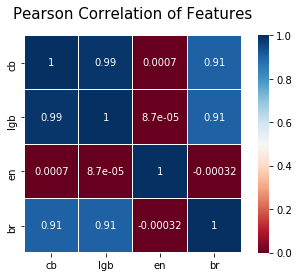

In [115]:
cor = train_stack[test_stack.columns].corr() 
colormap = plt.cm.RdBu
plt.figure(figsize=(6,4))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(cor,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [112]:
test_stack.head()

,cb,lgb,en,br
0,8.072049,8.278855,7.720801,7.931101
1,7.393346,7.458092,7.720801,7.182739
2,7.530636,7.621531,7.720801,7.597316
3,7.851403,7.917948,7.720801,7.848843
4,7.753336,7.769867,7.720801,7.610870


In [109]:
catboost_params = {'iterations': 1000,
                   'learning_rate': 0.03,
                   'depth': 8,
                   'loss_function': 'RMSE',
                   'eval_metric': 'RMSE',
                   'random_seed': 0,
                   'l2_leaf_reg': 3,
                   'verbose': 50,
                   'task_type': 'GPU',
                  }
model = cb.CatBoostRegressor()
model.set_params(**catboost_params)
model.fit(X=train_stack[test_stack.columns], y=train_stack[target_col_name])

0:	learn: 7.5672718	total: 8.18ms	remaining: 8.18s
50:	learn: 1.9075926	total: 340ms	remaining: 6.32s
100:	learn: 1.0398710	total: 623ms	remaining: 5.54s
150:	learn: 0.9790902	total: 918ms	remaining: 5.16s
200:	learn: 0.9757030	total: 1.22s	remaining: 4.86s
250:	learn: 0.9751615	total: 1.51s	remaining: 4.52s
300:	learn: 0.9747953	total: 1.8s	remaining: 4.19s
350:	learn: 0.9744696	total: 2.1s	remaining: 3.88s
400:	learn: 0.9741572	total: 2.41s	remaining: 3.61s
450:	learn: 0.9738794	total: 2.74s	remaining: 3.34s
500:	learn: 0.9736019	total: 3.08s	remaining: 3.06s
550:	learn: 0.9733407	total: 3.42s	remaining: 2.78s
600:	learn: 0.9730849	total: 3.75s	remaining: 2.49s
650:	learn: 0.9728579	total: 4.04s	remaining: 2.17s
700:	learn: 0.9726250	total: 4.33s	remaining: 1.85s
750:	learn: 0.9724011	total: 4.63s	remaining: 1.53s
800:	learn: 0.9721797	total: 4.96s	remaining: 1.23s
850:	learn: 0.9719552	total: 5.29s	remaining: 926ms
900:	learn: 0.9717371	total: 5.59s	remaining: 615ms
950:	learn: 0.97

In [110]:
en = ElasticNet()
en.fit(X=train_stack[test_stack.columns], y=train_stack[target_col_name])

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [113]:
sub_stack_cb = pd.DataFrame({'reservation_id': test_df['reservation_id']})
sub_stack_cb[target_col_name] = model.predict(test_stack)
sub_stack_cb.to_csv('sub_stack_cb.csv', index=False)
FileLink('sub_stack_cb.csv')

/kaggle/working/sub_stack_cb.csv

In [114]:
sub_stack_en = pd.DataFrame({'reservation_id': test_df['reservation_id']})
sub_stack_en[target_col_name] = en.predict(test_stack)
sub_stack_en.to_csv('sub_stack_en.csv', index=False)
FileLink('sub_stack_en.csv')

/kaggle/working/sub_stack_en.csv

In [120]:
sub_stack_mean = pd.DataFrame({'reservation_id': test_df['reservation_id']})
sub_stack_mean[target_col_name] = test_stack.mean(axis=1)
sub_stack_mean.to_csv('sub_stack_mean.csv', index=False)
FileLink('sub_stack_mean.csv')

/kaggle/working/sub_stack_mean.csv

In [121]:
sub_stack_temp = pd.DataFrame({'reservation_id': test_df['reservation_id']})
sub_stack_temp[target_col_name] = (70 * sub_stack_cb[target_col_name] + 30 * sub_stack_en[target_col_name])/100
sub_stack_temp.to_csv('sub_stack_temp.csv', index=False)
FileLink('sub_stack_temp.csv')

/kaggle/working/sub_stack_temp.csv